# 使用国内资产复现bender的论文

In [18]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

In [19]:
date_range = [datetime(2014,1,1), datetime(2021,12,31)]

## 1.按步骤分解

In [20]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
asset_data = asset_data_raw.rolling(22).mean()

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data.index).fillna(method='ffill').rolling(22).mean()
factor_data = factor_data_raw.rolling(22).mean()

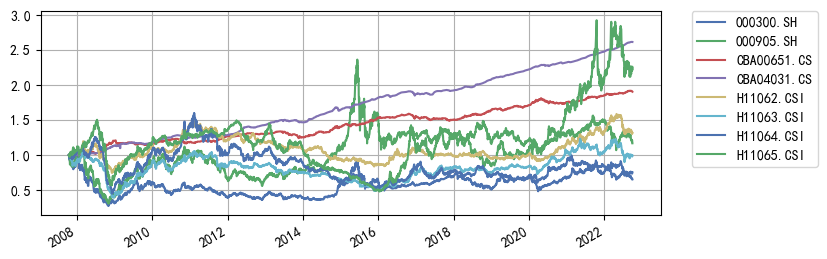

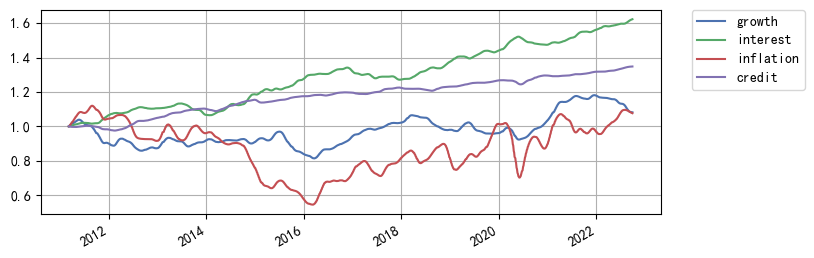

In [21]:
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

(factor_data.dropna()/factor_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [22]:
id_date = datetime(2019, 3, 31)
look_back = 252*3

tmp_asset_data = asset_data.loc[:id_date].iloc[-look_back:]
tmp_factor_data = factor_data.loc[:id_date].iloc[-look_back:]

asset_returns = tmp_asset_data.pct_change().fillna(0)
factor_returns = tmp_factor_data.pct_change().fillna(0)



### Step 2： Estimating Asset Class Factor Exposures

In [23]:
exposure = getFatorExposureFrame(asset_returns, factor_returns)
exposure

,growth,interest,inflation,credit
000300.SH,0.930664,-0.659634,-0.696464,0.862968
000905.SH,1.637431,0.237341,-0.132209,0.918660
CBA00651.CS,-0.319662,1.432393,-1.463571,-1.538925
CBA04031.CS,-1.370486,1.391461,-0.877398,0.072313
H11062.CSI,0.027646,-0.884551,1.414748,-0.927145
H11063.CSI,-0.183142,-0.635063,0.042614,-0.044895
H11064.CSI,-1.128361,-1.128719,0.614984,-0.661533
H11065.CSI,0.405910,0.246772,1.097296,1.318556


### Step 3: Constructing Factor-Mimicking Portfolios

In [24]:
fmp = getFactorMimickingPortfolio(asset_returns, factor_returns)
fmp

,growth,interest,inflation,credit,intercept
000300.SH,0.016832,-0.491949,-0.432001,0.156240,0.316245
000905.SH,0.173090,0.327630,0.248606,0.022032,-0.006310
CBA00651.CS,0.214961,0.084291,-0.236086,-0.392637,-0.004782
CBA04031.CS,-0.370319,0.182782,0.138286,0.333731,0.339121
H11062.CSI,0.053245,-0.024350,0.355496,-0.091179,0.431215
H11063.CSI,0.054993,-0.037030,-0.052589,0.071128,0.091424
H11064.CSI,-0.214221,-0.136545,-0.064120,-0.134422,-0.164131
H11065.CSI,0.071421,0.095170,0.042408,0.035107,-0.002783


In [25]:
# fmp回测表现
class FmpStrategy(Strategy):
    def __init__(self, factor_data=None, factor_name=None, scale=1):
        super().__init__()
        self._factor_data = factor_data
        self._factor_name = factor_name
        self._scale = scale

    def run(self, id_date, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        tmp_asset_returns = asset_data.pct_change().fillna(0)
        tmp_factor_data = self._factor_data.reindex(asset_data.index)
        tmp_factor_returns = tmp_factor_data.pct_change().fillna(0)

        return getFactorMimickingPortfolio(tmp_asset_returns, tmp_factor_returns, scale=self._scale)[self._factor_name]
      

In [26]:
fmp_value = pd.DataFrame()
fmp_weights = {}

for factor in ['intercept']+list(factor_data.columns):
    fmp_backtest = BacktestManager(
        FmpStrategy(factor_data=factor_data, factor_name=factor, scale=None), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = 22, 
        look_back = 252*3, 
    )
    fmp_backtest.run()
    fmp_value[factor] = fmp_backtest.getHistoricalValue()
    weights_dict = fmp_backtest._historcial_weights
    fmp_weights[factor] = pd.DataFrame(columns=asset_data.columns)
    for id_date, weights in weights_dict.items():
        fmp_weights[factor].loc[id_date] = weights.reindex(fmp_weights[factor].columns)



100%|██████████| 1950/1950 [00:12<00:00, 152.54it/s]


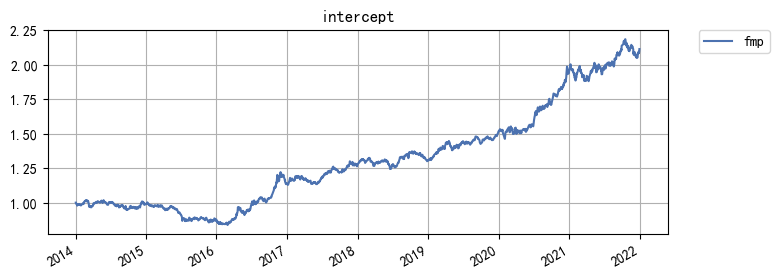

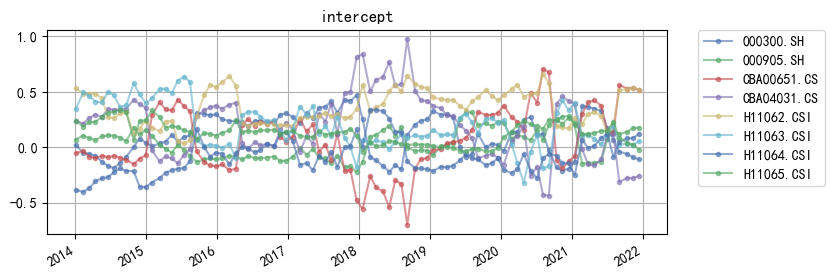

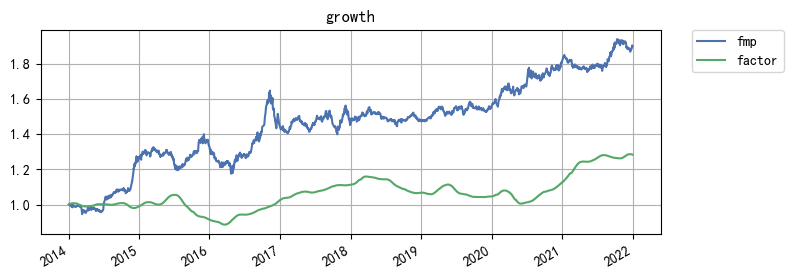

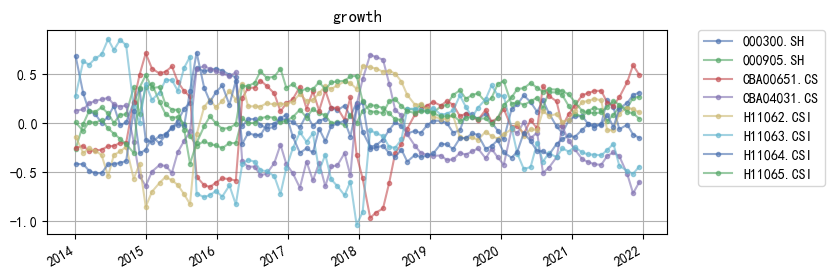

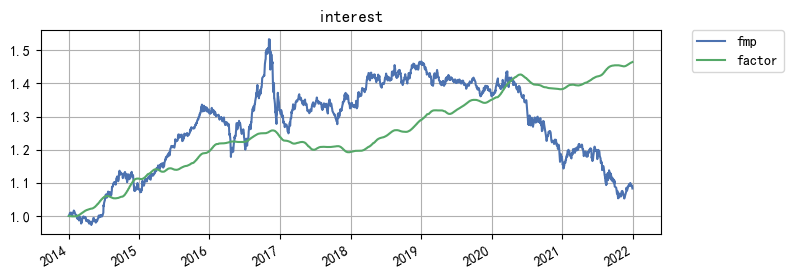

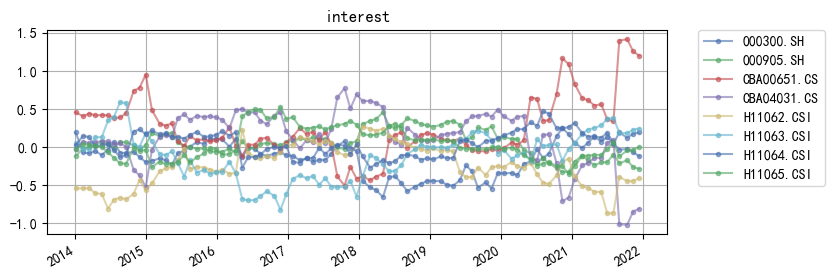

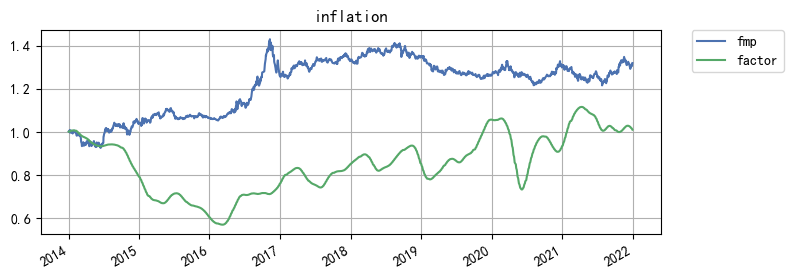

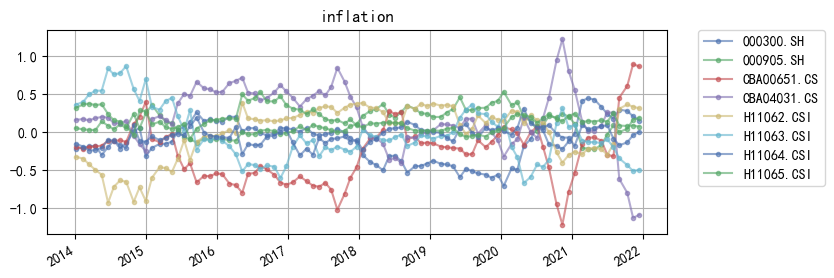

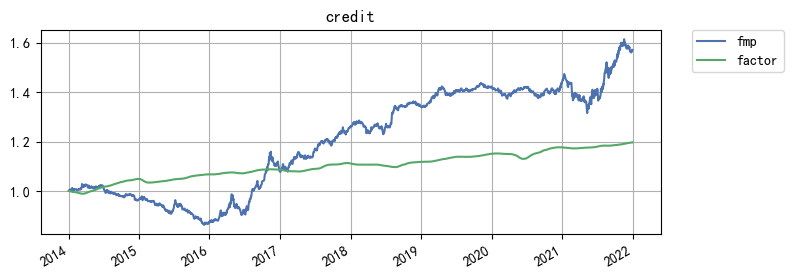

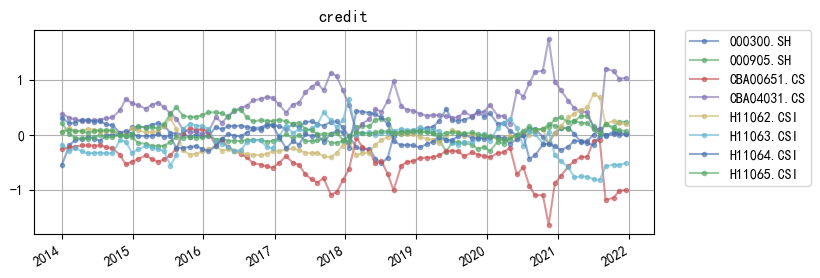

In [27]:
tmp_factor_data = factor_data.reindex(fmp_value.index)
tmp_factor_data /= tmp_factor_data.iloc[0]
fmp_value /= fmp_value.iloc[0]

for factor in ['intercept']+list(factor_data.columns):
    df = pd.DataFrame()
    df['fmp'] = fmp_value[factor]
    if factor != 'intercept':
        df['factor'] = tmp_factor_data[factor]
    df.plot(figsize=(8,3), grid=True, title=factor)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

    fmp_weights[factor].plot(figsize=(8,3), grid=True, title=factor, alpha=0.6, style='.-')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)



### Step 4: Forecasting Factor-Mimicking Portfolio Return

In [28]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
tmp_fmp_returns = fmp_value.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)


### Step 5: Constructing the Optimal Factor Portfolio

In [29]:
opt_fmp_weights = optimalFactorPortfolio(tmp_fmp_returns)
opt_fmp_weights

,intercept,growth,interest,inflation,credit
0,12.921779,-18.619359,-0.956203,-9.416787,17.070569


### Step 6: Inferring Expected Returns for Asset Classes

In [30]:
tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-252:]
alpha = getAssetExpectedReturns(opt_fmp_weights, fmp, tmp_asset_returns)
alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
0,0.377287,0.191461,0.001433,0.000896,0.166336,0.145599,0.115024,0.092767


In [31]:
class AssetAlphaStrategy(Strategy):
    def __init__(self, fmp_value):
        super().__init__()
        self._asset_alpha = pd.DataFrame(columns=list(asset_data.columns))
        self._opt_fp_df = pd.DataFrame(columns=list(fmp_value))
        self._fmp_returns = fmp_value.pct_change()

    def run(self, id_date, asset_data):
        opt_fp = optimalFactorPortfolio(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        self._opt_fp_df.loc[id_date] = list(opt_fp.values[0])
        tmp_fmp_weights = pd.DataFrame({factor: v.loc[id_date].reindex(list(asset_data.columns)) for factor,v in fmp_weights.items()})
        tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-fmp_lookback:]
        self._asset_alpha.loc[id_date] = list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0])
        return pd.Series([0]*asset_data.shape[1], index=asset_data.columns)
        

In [35]:
date_range = [datetime(2015,1,30), datetime(2021,12,31)]
aa_backtest = BacktestManager(
    AssetAlphaStrategy(fmp_value), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
aa_backtest.run()

  2%|▏         | 33/1686 [00:00<00:14, 110.66it/s]

2015-01-30 00:00:00: skip
2015-03-10 00:00:00: skip


  4%|▍         | 66/1686 [00:00<00:12, 127.58it/s]

2015-04-10 00:00:00: skip
2015-05-13 00:00:00: skip


  6%|▋         | 106/1686 [00:01<00:14, 107.44it/s]

2015-06-12 00:00:00: skip
2015-07-15 00:00:00: skip


  9%|▉         | 155/1686 [00:01<00:11, 133.11it/s]

2015-08-14 00:00:00: skip
2015-09-17 00:00:00: skip


 12%|█▏        | 208/1686 [00:01<00:10, 147.20it/s]

2015-10-26 00:00:00: skip
2015-11-25 00:00:00: skip


 14%|█▍        | 243/1686 [00:01<00:10, 142.16it/s]

2015-12-25 00:00:00: skip
2016-01-27 00:00:00: skip


 17%|█▋        | 281/1686 [00:02<00:09, 143.99it/s]

2016-03-04 00:00:00: skip
2016-04-06 00:00:00: skip


 20%|█▉        | 333/1686 [00:02<00:08, 164.83it/s]

2016-05-09 00:00:00: skip
2016-06-08 00:00:00: skip


 22%|██▏       | 372/1686 [00:02<00:07, 170.53it/s]

2016-07-12 00:00:00: skip
2016-08-11 00:00:00: skip


 24%|██▍       | 407/1686 [00:03<00:10, 127.02it/s]

2016-09-12 00:00:00: skip


 27%|██▋       | 453/1686 [00:03<00:09, 130.47it/s]

2016-10-21 00:00:00: skip
2016-11-22 00:00:00: skip


 29%|██▉       | 490/1686 [00:03<00:07, 152.69it/s]

2016-12-22 00:00:00: skip
2017-01-24 00:00:00: skip


 31%|███       | 525/1686 [00:03<00:07, 156.65it/s]

2017-03-02 00:00:00: skip
2017-04-05 00:00:00: skip


 34%|███▍      | 572/1686 [00:04<00:09, 121.68it/s]

2017-05-08 00:00:00: skip


 36%|███▌      | 599/1686 [00:04<00:08, 123.05it/s]

2017-06-09 00:00:00: skip
2017-07-11 00:00:00: skip


 37%|███▋      | 630/1686 [00:04<00:08, 123.04it/s]

2017-08-10 00:00:00: skip


 39%|███▉      | 655/1686 [00:05<00:09, 108.66it/s]

2017-09-11 00:00:00: skip


 40%|████      | 678/1686 [00:05<00:10, 98.07it/s] 

2017-10-18 00:00:00: skip


 42%|████▏     | 705/1686 [00:05<00:09, 100.67it/s]

2017-11-17 00:00:00: skip
2017-12-19 00:00:00: skip


 44%|████▍     | 742/1686 [00:05<00:08, 105.65it/s]

2018-01-19 00:00:00: skip
2018-02-27 00:00:00: skip


 47%|████▋     | 793/1686 [00:06<00:08, 102.52it/s]

2018-03-29 00:00:00: skip
2018-05-04 00:00:00: skip


 49%|████▉     | 833/1686 [00:06<00:06, 131.06it/s]

2018-06-05 00:00:00: skip


 51%|█████     | 860/1686 [00:07<00:07, 112.43it/s]

2018-07-06 00:00:00: skip
2018-08-07 00:00:00: skip


 53%|█████▎    | 896/1686 [00:07<00:06, 131.23it/s]

2018-09-06 00:00:00: skip
2018-10-16 00:00:00: skip


 56%|█████▌    | 946/1686 [00:07<00:05, 147.87it/s]

2018-11-15 00:00:00: skip
2018-12-17 00:00:00: skip


 59%|█████▉    | 995/1686 [00:08<00:06, 115.12it/s]

2019-01-18 00:00:00: skip
2019-02-26 00:00:00: skip


 61%|██████▏   | 1035/1686 [00:08<00:04, 139.46it/s]

2019-03-28 00:00:00: skip
2019-04-30 00:00:00: skip


 64%|██████▍   | 1075/1686 [00:08<00:03, 156.03it/s]

2019-06-04 00:00:00: skip


 65%|██████▍   | 1092/1686 [00:08<00:04, 138.23it/s]

2019-07-05 00:00:00: skip
2019-08-06 00:00:00: skip


 68%|██████▊   | 1151/1686 [00:09<00:03, 134.59it/s]

2019-09-05 00:00:00: skip
2019-10-15 00:00:00: skip


 70%|███████   | 1185/1686 [00:09<00:03, 141.15it/s]

2019-11-14 00:00:00: skip
2019-12-16 00:00:00: skip


 73%|███████▎  | 1225/1686 [00:09<00:04, 97.91it/s] 

2020-01-16 00:00:00: skip


 74%|███████▍  | 1247/1686 [00:10<00:04, 89.21it/s]

2020-02-25 00:00:00: skip


 75%|███████▌  | 1269/1686 [00:10<00:04, 88.08it/s]

2020-03-26 00:00:00: skip


 76%|███████▋  | 1289/1686 [00:10<00:04, 82.08it/s]

2020-04-28 00:00:00: skip


 78%|███████▊  | 1320/1686 [00:11<00:03, 111.57it/s]

2020-06-02 00:00:00: skip
2020-07-06 00:00:00: skip


 81%|████████  | 1365/1686 [00:11<00:02, 133.72it/s]

2020-08-05 00:00:00: skip
2020-09-04 00:00:00: skip


 83%|████████▎ | 1403/1686 [00:11<00:01, 153.36it/s]

2020-10-14 00:00:00: skip
2020-11-13 00:00:00: skip


 86%|████████▌ | 1447/1686 [00:11<00:01, 124.78it/s]

2020-12-15 00:00:00: skip


 87%|████████▋ | 1475/1686 [00:12<00:01, 112.21it/s]

2021-01-15 00:00:00: skip
2021-02-23 00:00:00: skip


 90%|████████▉ | 1514/1686 [00:12<00:01, 116.09it/s]

2021-03-25 00:00:00: skip


 91%|█████████▏| 1539/1686 [00:12<00:01, 112.66it/s]

2021-04-27 00:00:00: skip


 92%|█████████▏| 1551/1686 [00:12<00:01, 105.50it/s]

2021-06-01 00:00:00: skip


 93%|█████████▎| 1573/1686 [00:13<00:01, 92.30it/s] 

2021-07-02 00:00:00: skip


 94%|█████████▍| 1593/1686 [00:13<00:01, 69.57it/s]

2021-08-03 00:00:00: skip


 97%|█████████▋| 1630/1686 [00:13<00:00, 97.73it/s]

2021-09-02 00:00:00: skip
2021-10-13 00:00:00: skip


 99%|█████████▉| 1667/1686 [00:14<00:00, 129.37it/s]

2021-11-12 00:00:00: skip
2021-12-14 00:00:00: skip


100%|██████████| 1686/1686 [00:14<00:00, 118.61it/s]


## 2. 复现结果

In [36]:
# fmp
fmp_value

,intercept,growth,interest,inflation,credit
2014-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,0.993856,0.998657,1.001415,0.998238,1.001441
2014-01-06,0.988969,0.996428,1.004557,1.003802,1.004559
2014-01-07,0.991163,1.002286,1.007132,1.007631,1.000441
2014-01-08,0.989908,1.003366,1.009128,1.007541,0.999150
...,...,...,...,...,...
2021-12-27,2.083681,1.885078,1.091365,1.309085,1.569304
2021-12-28,2.094902,1.890378,1.089592,1.313200,1.568621
2021-12-29,2.087293,1.896943,1.091889,1.307068,1.565361
2021-12-30,2.096189,1.903813,1.088762,1.314447,1.570024


In [37]:
# asset alpha
aa_backtest._strategy._asset_alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2015-01-30,-0.017367,0.173296,0.025684,-0.000157,-0.252470,-0.063417,-0.094022,0.164143
2015-03-10,-0.145016,0.042014,0.029515,0.000834,-0.252854,-0.091850,-0.161474,0.059475
2015-04-10,-0.254100,0.014311,0.043650,0.000034,-0.212651,-0.006768,-0.106218,-0.037312
2015-05-13,-0.283122,0.061616,0.062731,0.003203,-0.164999,0.008464,-0.073152,-0.117253
2015-06-12,-0.116572,0.233350,0.066558,0.006310,-0.283406,-0.045449,-0.141737,-0.202018
...,...,...,...,...,...,...,...,...
2021-08-03,-0.036186,0.020516,0.001840,0.002116,0.351908,0.183871,0.190769,0.114556
2021-09-02,-0.012667,0.069933,-0.008568,0.002051,0.263901,0.262521,0.265572,0.337753
2021-10-13,-0.068182,0.044599,-0.011772,0.001981,0.256693,0.256602,0.315073,0.358707
2021-11-12,-0.009993,0.059719,-0.009781,0.001523,0.218025,0.123270,0.177696,0.244535


In [38]:
aa_backtest._strategy._asset_alpha.to_csv(os.path.join(this_path, '../data/assets/asset_alpha.csv'))